Project 3: Classification

The goal of this project is to build a machine learning model to predict a category for a dataset.

For this project, I use Sonoma County's Animal Shelter Intake and Outake data to predict the likelihood an animal will be returned from adoption.

In this notebook, I optimize my final model: XGBoost. I tune different hyperparameters and examine different sampling strategies. I use XGBoost over the other models because it has given me the highest f-score, and I believe it has the highest potential to best classify my data.

### Table of Contents
1. Imports
2. First Round: Compare Sampling Strategies
3. Second Round: Tune Hyperparameters
4. Final Model
5. Tableau Prep

### 1. Imports

In [1]:
# standard imports
import pandas as pd
import numpy as np 
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# classification imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support as prfs_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# oversample my minority class and undersample my majority class
import imblearn.over_sampling
import imblearn.under_sampling

### 2. First Round: Compare Sampling Strategies

In [2]:
# load in data
with open("data/animal_cleaned_df.pickle", 'rb') as read_file:
    animal_df = pickle.load(read_file)

In [3]:
# prep data for classification
columns_to_keep = ["type", "size", "age", "gender", "has_name", "spay_neuter", "intake_condition", "pit_bull", "intake_location", "adopt_return"]
class_df = animal_df[columns_to_keep].copy()

# dropping 31 rows where size is null (0.1% of my data)
print(class_df[class_df["size"].isnull()].shape)
class_df = class_df[class_df["size"].notna()].reset_index(drop=True)

# Since age is a whole number, I impute with the median value rather than the mean
print(class_df["age"].mean(), class_df["age"].median())
class_df["age"].fillna(class_df["age"].median(), inplace=True)

(31, 10)
7.883664858348403 7.0


In [4]:
class_df.info() # double check for null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19659 entries, 0 to 19658
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              19659 non-null  object 
 1   size              19659 non-null  object 
 2   age               19659 non-null  float64
 3   gender            19659 non-null  object 
 4   has_name          19659 non-null  int64  
 5   spay_neuter       19659 non-null  int64  
 6   intake_condition  19659 non-null  object 
 7   pit_bull          19659 non-null  int64  
 8   intake_location   19659 non-null  object 
 9   adopt_return      19659 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 1.5+ MB


In [6]:
def oversample_data(X, y, oversample_amnt):
    '''
    This function returns data that oversamples the minority class.
    Input:
    - X (DataFrame): dataframe of features to be oversampled
    - y (Series): series of target variable
    - oversample_amnt (int): multiplcative factor to oversample by (i.e. 2 times or 3 times)
    Output:
    - X_os (DataFrame): oversampled X dataframe
    - y_os (Series): oversampled y series
    
    '''
    n_pos = np.sum(y == 1)
    n_neg = np.sum(y == 0)
    ratio = {1: (n_pos * oversample_amnt), 0: n_neg}
    
    ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy=ratio, random_state=202)
    X_os, y_os = ROS.fit_sample(X, y)
    
    return X_os, y_os

In [5]:
def undersample_data(X, y, undersample_amnt):
    '''
    This function returns data that undersamples the majority class.
    Input:
    - X (DataFrame): dataframe of features to be undersampled
    - y (Series): series of target variable
    - undersample_amnt (float): ratio to undersample by (i.e. 1/2 or 1/3)
    Output:
    - X_us (DataFrame): undersampled X dataframe
    - y_us (Series): undersampled y series
    
    '''
    n_pos = np.sum(y == 1)
    n_neg = np.sum(y == 0)
    ratio = {1:n_pos, 0:int(n_neg * undersample_amnt)}
    
    RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=ratio, random_state=202)
    X_us, y_us = RUS.fit_sample(X, y)
    
    return X_us, y_us

In [6]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    '''
    This function plots a confusion matrix for true vs predicted values.
    Input:
    - y_true (array): list of actual y values
    - y_pred (array): list of predicied y values
    - model_name (str): name of the model
    Output:
    - heatmap for confusion matrix
    '''    
    
    cf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(cf_matrix, cmap=plt.cm.Blues, annot=True, fmt='d', xticklabels=["No Return", "Adoption Return"], yticklabels=["No Return", "Adoption Return"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.savefig('images/final_confusion_matrix.png', format='png');

In [7]:
# for XGBoost, I still need to make dummy variables, but I don't need to scale my age column
# I also don't need to drop any dummy variables because I'm not doing logistic regression
X = class_df.drop(columns=["adopt_return"])
X = pd.get_dummies(X)
y = class_df["adopt_return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=202, stratify=y)

In [25]:
# first round of hyperparameters to test
n_estimators_range = [100, 500, 1000, 2000, 3000, 5000]
max_depth_range = [x for x in range(10,31)]
learning_rate_range = list(np.linspace(0,1,10, endpoint=False))
subsample_range = list(np.linspace(0.3,1,7,endpoint=False))
reg_alpha_range = [1, 2, 3, 4]
reg_lambda_range = [0, 1, 2, 3]
scale_pos_weight_range = [1, 3, 5, 7, 8, 10, 15, 20]

param_grid = dict(n_estimators=n_estimators_range,
                  max_depth=max_depth_range,
                  objective=['binary:logistic'],
                  learning_rate=learning_rate_range,
                  subsample=subsample_range,
                  reg_alpha=reg_alpha_range,
                  reg_lambda=reg_lambda_range,
                  scale_pos_weight=scale_pos_weight_range
                 )

In [26]:
# oversample my minority class by 5 times
X_train_os, y_train_os = oversample_data(X_train, y_train, 5)

xgboost = xgb.XGBClassifier()
xgboost_search = RandomizedSearchCV(xgboost, param_grid, n_iter=10, scoring='roc_auc')
fit_model = xgboost_search.fit(X_train_os, y_train_os)
fit_model.best_params_

{'subsample': 0.7999999999999999,
 'scale_pos_weight': 15,
 'reg_lambda': 2,
 'reg_alpha': 3,
 'objective': 'binary:logistic',
 'n_estimators': 100,
 'max_depth': 17,
 'learning_rate': 0.30000000000000004}

In [27]:
xgboost_pred = fit_model.predict(X_test)

xgboost_results = []

accuracy = accuracy_score(y_test, xgboost_pred)
precision, recall, fscore, support = prfs_score(y_test, xgboost_pred, pos_label=1, average='binary', zero_division=0)
roc_score = roc_auc_score(y_test, xgboost_pred)

model_scores_dict = {
                        'Model': 'XGBoost with Randomized Search',
                        'Sampling Strategy': 'Oversampled by 5',
                        'Parameter_1': f'None',
                        'Parameter_2': f'None',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
xgboost_results.append(model_scores_dict)
    
xgboost_results_df = pd.DataFrame(data=xgboost_results)
xgboost_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,XGBoost with Randomized Search,Oversampled by 5,None,None,0.89,0.06,0.38,0.1,0.64


In [28]:
# undersample my majority class by half
X_train_us, y_train_us = undersample_data(X_train, y_train, 0.5)

xgboost = xgb.XGBClassifier()
xgboost_search = RandomizedSearchCV(xgboost, param_grid, n_iter=10, scoring='roc_auc')
fit_model = xgboost_search.fit(X_train_us, y_train_us)
fit_model.best_params_

{'subsample': 0.8999999999999999,
 'scale_pos_weight': 1,
 'reg_lambda': 3,
 'reg_alpha': 4,
 'objective': 'binary:logistic',
 'n_estimators': 500,
 'max_depth': 22,
 'learning_rate': 0.8}

In [29]:
xgboost_pred = fit_model.predict(X_test)

xgboost_results = []

accuracy = accuracy_score(y_test, xgboost_pred)
precision, recall, fscore, support = prfs_score(y_test, xgboost_pred, pos_label=1, average='binary', zero_division=0)
roc_score = roc_auc_score(y_test, xgboost_pred)

model_scores_dict = {
                        'Model': 'XGBoost with Randomized Search',
                        'Sampling Strategy': 'Undersampled by 0.5',
                        'Parameter_1': f'None',
                        'Parameter_2': f'None',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
xgboost_results.append(model_scores_dict)
    
xgboost_results_df = pd.DataFrame(data=xgboost_results)
xgboost_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,XGBoost with Randomized Search,Undersampled by 0.5,None,None,0.98,0.46,0.09,0.15,0.54


In [30]:
# undersample my majority class by a third
X_train_us, y_train_us = undersample_data(X_train, y_train, 0.3)

xgboost = xgb.XGBClassifier()
xgboost_search = RandomizedSearchCV(xgboost, param_grid, n_iter=10, scoring='roc_auc')
fit_model = xgboost_search.fit(X_train_us, y_train_us)
fit_model.best_params_

{'subsample': 0.39999999999999997,
 'scale_pos_weight': 5,
 'reg_lambda': 0,
 'reg_alpha': 3,
 'objective': 'binary:logistic',
 'n_estimators': 1000,
 'max_depth': 18,
 'learning_rate': 0.1}

In [31]:
xgboost_pred = fit_model.predict(X_test)

xgboost_results = []

accuracy = accuracy_score(y_test, xgboost_pred)
precision, recall, fscore, support = prfs_score(y_test, xgboost_pred, pos_label=1, average='binary', zero_division=0)
roc_score = roc_auc_score(y_test, xgboost_pred)

model_scores_dict = {
                        'Model': 'XGBoost with Randomized Search',
                        'Sampling Strategy': 'Undersampled by 1/3',
                        'Parameter_1': f'None',
                        'Parameter_2': f'None',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
xgboost_results.append(model_scores_dict)
    
xgboost_results_df = pd.DataFrame(data=xgboost_results)
xgboost_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,XGBoost with Randomized Search,Undersampled by 1/3,None,None,0.93,0.08,0.29,0.13,0.62


In [32]:
# undersample my majority class by a tenth
X_train_us, y_train_us = undersample_data(X_train, y_train, 0.1)

xgboost = xgb.XGBClassifier()
xgboost_search = RandomizedSearchCV(xgboost, param_grid, n_iter=10, scoring='roc_auc')
fit_model = xgboost_search.fit(X_train_us, y_train_us)
fit_model.best_params_

{'subsample': 0.8999999999999999,
 'scale_pos_weight': 5,
 'reg_lambda': 2,
 'reg_alpha': 4,
 'objective': 'binary:logistic',
 'n_estimators': 100,
 'max_depth': 30,
 'learning_rate': 0.2}

In [33]:
xgboost_pred = fit_model.predict(X_test)

xgboost_results = []

accuracy = accuracy_score(y_test, xgboost_pred)
precision, recall, fscore, support = prfs_score(y_test, xgboost_pred, pos_label=1, average='binary', zero_division=0)
roc_score = roc_auc_score(y_test, xgboost_pred)

model_scores_dict = {
                        'Model': 'XGBoost with Randomized Search',
                        'Sampling Strategy': 'Undersampled by 1/10',
                        'Parameter_1': f'None',
                        'Parameter_2': f'None',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
xgboost_results.append(model_scores_dict)
    
xgboost_results_df = pd.DataFrame(data=xgboost_results)
xgboost_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,XGBoost with Randomized Search,Undersampled by 1/10,None,None,0.78,0.05,0.66,0.09,0.72


I tested:
* Oversampling my minority class by 5
* Undersampling my majority class by 0.5, 0,3 and 0.1
All F scores are around 0.1 and the ROC/AUC score is in the 0.6-0.7 range. My ideal metric is high recall because I want to find out the features most associated with the true population of adoption returns. However, I still want high F score and high ROC/AUC scores. It doesn't seem like the different sampling strategies produce results that are drastically different from one another.<br/>

Additionally, looking at the best parameters, there doesn't seem to be clear consensus. Because I used RandomizedSearchCV instead of GridSearchCV, the best parameters chosen don't always line up. Additionally because I used so many different sampling strategies, it's hard to interpret my results. For my second round of testing, I want to pick one sampling strategy and stick with it.

### 3. Second Round: Tune Hyperparameters

Going back to my original data, only around 1.7% of my data is from my target class. Oversampling means duplicating my minority class and will likely lead to overfitting. I'm a bigger fan of undersampling.

In my first round of testing, I undersampled by half, a third, and a tenth. Predictably, models with lower samples of the majority class had lower accuracy and higher ROC/AUC score. The F score also dropped from 0.15 to 0.13 to 0.09. Precision went from 0.46 to 0.08 to 0.05. Recall went from 0.09 to 0.29 to 0.66.

This is tough because I'm making a judgment call. Ultimately because my data is hugely imbalanced and I want greater separation between my positive and negative class, I will do my testing in the next round on data that undersampling my majority class by a tenth.

In [7]:
# for XGBoost, I still need to make dummy variables, but I don't need to scale my age column
# I also don't need to drop any dummy variables because I'm not doing a linear regression
X = class_df.drop(columns=["adopt_return"])
X = pd.get_dummies(X)
y = class_df["adopt_return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=202, stratify=y)

Here are the best parameters from my first round of testing with undersampling by a tenth.

```
{'subsample': 0.8999999999999999,
 'scale_pos_weight': 5,
 'reg_lambda': 2,
 'reg_alpha': 4,
 'objective': 'binary:logistic',
 'n_estimators': 100,
 'max_depth': 30,
 'learning_rate': 0.2}
```
When tuning my model, I'll reduce the scale of my number of estimators, test a higher range of max depths, look at lower learning rates, test similar subsample range (since I'm already undersampling), test out a few more alpha and lambda regularization parameters, and use the same positive weight scaling.

In [11]:
# second round of hyperparameters to test
n_estimators_range = [25, 50, 75, 100, 250, 500]
max_depth_range = [x for x in range(25,51)]
learning_rate_range = list(np.linspace(0,0.5,5, endpoint=False))
subsample_range = list(np.linspace(0.5,1,5,endpoint=False))
reg_alpha_range = [3, 4, 5, 6]
reg_lambda_range = [1, 2, 3, 4]
scale_pos_weight_range = [1, 3, 5, 7, 8, 10, 15, 20]

param_grid = dict(n_estimators=n_estimators_range,
                  max_depth=max_depth_range,
                  objective=['binary:logistic'],
                  learning_rate=learning_rate_range,
                  subsample=subsample_range,
                  reg_alpha=reg_alpha_range,
                  reg_lambda=reg_lambda_range,
                  scale_pos_weight=scale_pos_weight_range
                 )

In [12]:
# undersample my majority class by a tenth
X_train_us, y_train_us = undersample_data(X_train, y_train, 0.1)

xgboost = xgb.XGBClassifier()
xgboost_search = RandomizedSearchCV(xgboost, param_grid, n_iter=10, scoring='roc_auc', random_state=202)
fit_model = xgboost_search.fit(X_train_us, y_train_us)
fit_model.best_params_

{'subsample': 0.9,
 'scale_pos_weight': 3,
 'reg_lambda': 4,
 'reg_alpha': 3,
 'objective': 'binary:logistic',
 'n_estimators': 25,
 'max_depth': 45,
 'learning_rate': 0.2}

In [13]:
xgboost_pred = fit_model.predict(X_test)

xgboost_results = []

accuracy = accuracy_score(y_test, xgboost_pred)
precision, recall, fscore, support = prfs_score(y_test, xgboost_pred, pos_label=1, average='binary', zero_division=0)
roc_score = roc_auc_score(y_test, xgboost_pred)

model_scores_dict = {
                        'Model': 'XGBoost with Randomized Search',
                        'Sampling Strategy': 'Undersampled by 1/10',
                        'Parameter_1': f'None',
                        'Parameter_2': f'None',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
xgboost_results.append(model_scores_dict)
    
xgboost_results_df = pd.DataFrame(data=xgboost_results)
xgboost_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,XGBoost with Randomized Search,Undersampled by 1/10,None,None,0.85,0.07,0.6,0.12,0.73


I am pleasantly surprised by the results. 
* Accuracy was 0.78, but now it's up to 0.85 
* Precision increased from 0.05 to 0.07
* Recall decreased slightly from 0.66 to 0.6
* F score increased from 0.09 to 0.12
* ROC/AUC score increased from 0.72 to 0.73

Here are the best parameters from my second round of testing with undersampling by a tenth.

```
{'subsample': 0.9,
 'scale_pos_weight': 3,
 'reg_lambda': 4,
 'reg_alpha': 3,
 'objective': 'binary:logistic',
 'n_estimators': 25,
 'max_depth': 45,
 'learning_rate': 0.2}
```
I'll reduce the scale of my number of estimators, test a higher range of max depths, look at lower learning rates, keep subsample range as 0.9, test out a few more alpha and lambda regularization parameters, and test a narrower range of positive weight scaling.

In [14]:
# third round of hyperparameters to test
n_estimators_range = [5, 10, 15, 20, 25, 50]
max_depth_range = [x for x in range(40,61)]
learning_rate_range = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
subsample_range = [0.9]
reg_alpha_range = [2, 3, 4, 5, 6]
reg_lambda_range = [1, 2, 3, 4, 5]
scale_pos_weight_range = [1, 2, 3, 4, 5, 6, 7, 8]

param_grid = dict(n_estimators=n_estimators_range,
                  max_depth=max_depth_range,
                  objective=['binary:logistic'],
                  learning_rate=learning_rate_range,
                  subsample=subsample_range,
                  reg_alpha=reg_alpha_range,
                  reg_lambda=reg_lambda_range,
                  scale_pos_weight=scale_pos_weight_range
                 )

In [15]:
# undersample my majority class by a tenth
X_train_us, y_train_us = undersample_data(X_train, y_train, 0.1)

xgboost = xgb.XGBClassifier()
xgboost_search = RandomizedSearchCV(xgboost, param_grid, n_iter=10, scoring='roc_auc', random_state=202)
fit_model = xgboost_search.fit(X_train_us, y_train_us)
fit_model.best_params_

{'subsample': 0.9,
 'scale_pos_weight': 2,
 'reg_lambda': 5,
 'reg_alpha': 6,
 'objective': 'binary:logistic',
 'n_estimators': 20,
 'max_depth': 49,
 'learning_rate': 0.2}

In [16]:
xgboost_pred = fit_model.predict(X_test)

xgboost_results = []

accuracy = accuracy_score(y_test, xgboost_pred)
precision, recall, fscore, support = prfs_score(y_test, xgboost_pred, pos_label=1, average='binary', zero_division=0)
roc_score = roc_auc_score(y_test, xgboost_pred)

model_scores_dict = {
                        'Model': 'XGBoost with Randomized Search',
                        'Sampling Strategy': 'Undersampled by 1/10',
                        'Parameter_1': f'None',
                        'Parameter_2': f'None',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
xgboost_results.append(model_scores_dict)
    
xgboost_results_df = pd.DataFrame(data=xgboost_results)
xgboost_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,XGBoost with Randomized Search,Undersampled by 1/10,None,None,0.95,0.12,0.34,0.18,0.65


Interesting results. 
* Accuracy increased a ton from 0.85 to 0.95
* Precision also increased from 0.07 to 0.12
* Recall decreased from 0.6 to 0.34
* F score increased from 0.12 to 0.34
* ROC/AUC score decreased from 0.73 to 0.65<br/>

Overall, I'm happy with the increase in F score, but the decrease in Recall from 0.6 to 0.34 isn't great. Although I want a higher F score, I am willing to decrease my model's precision for higher recall. 

In [21]:
# fourth round of hyperparameters to test; using GridSearchCV to try to get the best model
n_estimators_range = [x for x in range(15, 25)]
max_depth_range = [47, 49, 51, 53]
learning_rate_range = [0.15, 0.175, 0.2, 0.225, 0.25]
subsample_range = [0.9]
reg_alpha_range = [5, 5.5, 6, 6.5, 7]
reg_lambda_range = [4.5, 5, 5.5, 6, 6.5]
scale_pos_weight_range = [1.5, 1.75, 2, 2.25, 2.5]

param_grid = dict(n_estimators=n_estimators_range,
                  max_depth=max_depth_range,
                  objective=['binary:logistic'],
                  learning_rate=learning_rate_range,
                  subsample=subsample_range,
                  reg_alpha=reg_alpha_range,
                  reg_lambda=reg_lambda_range,
                  scale_pos_weight=scale_pos_weight_range
                 )

In [24]:
# undersample my majority class by a tenth
X_train_us, y_train_us = undersample_data(X_train, y_train, 0.1)

# GridSearchCV
xgboost = xgb.XGBClassifier()
xgboost_search = GridSearchCV(xgboost, param_grid, scoring='roc_auc')
fit_model = xgboost_search.fit(X_train_us, y_train_us)
fit_model.best_params_

{'learning_rate': 0.225,
 'max_depth': 47,
 'n_estimators': 20,
 'objective': 'binary:logistic',
 'reg_alpha': 5,
 'reg_lambda': 6.5,
 'scale_pos_weight': 2.5,
 'subsample': 0.9}

In [25]:
xgboost_pred = fit_model.predict(X_test)

xgboost_results = []

accuracy = accuracy_score(y_test, xgboost_pred)
precision, recall, fscore, support = prfs_score(y_test, xgboost_pred, pos_label=1, average='binary', zero_division=0)
roc_score = roc_auc_score(y_test, xgboost_pred)

model_scores_dict = {
                        'Model': 'XGBoost with GridSearch',
                        'Sampling Strategy': 'Undersampled by 1/10',
                        'Parameter_1': f'None',
                        'Parameter_2': f'None',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
xgboost_results.append(model_scores_dict)
    
xgboost_results_df = pd.DataFrame(data=xgboost_results)
xgboost_results_df

,Model,Sampling Strategy,Parameter_1,Parameter_2,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,XGBoost with GridSearch,Undersampled by 1/10,None,None,0.89,0.08,0.47,0.13,0.69


Putting best parameters in a markdown cell for future reference
```
{'learning_rate': 0.225,
 'max_depth': 47,
 'n_estimators': 20,
 'objective': 'binary:logistic',
 'reg_alpha': 5,
 'reg_lambda': 6.5,
 'scale_pos_weight': 2.5,
 'subsample': 0.9}
 ```


Results 
* Accuracy decreased from 0.95 to 0.89
* Precision decreased from 0.12 to 0.08
* Recall increased from 0.34 to 0.47
* F score decreased from 0.34 to 0.13
* ROC/AUC score increased from 0.65 to 0.69<br/>

Recall is higher, but other metrics (accuracy, precision, and F score) all decreased.

### 3. Final Model

Here, I build my final XGBoost model. The final thing I can do is to adjust the threshold to get a higher recall.

In [8]:
# undersample my majority class by a tenth
X_train_us, y_train_us = undersample_data(X_train, y_train, 0.1)

# use parameters from GridSearchCV
xgboost = xgb.XGBClassifier(
                           n_estimators=20,
                           max_depth=47,
                           objective='binary:logistic',
                           learning_rate=0.225,
                           subsample=0.9,
                           scale_pos_weight=2.5,
                           reg_alpha=5,
                           reg_lambda=6.5
                           )
fit_model = xgboost.fit(X_train_us, y_train_us)

In [10]:
threshold_list = np.linspace(0.3,0.5,20)
xgboost_results = []

for threshold in threshold_list:
    xgboost_pred = xgboost.predict_proba(X_test)
    xgboost_pred = (xgboost_pred[:,1] >= threshold).astype('int')
    
    accuracy = accuracy_score(y_test, xgboost_pred)
    precision, recall, fscore, support = prfs_score(y_test, xgboost_pred, pos_label=1, average='binary', zero_division=0)
    roc_score = roc_auc_score(y_test, xgboost_pred)

    model_scores_dict = {
                        'Model': 'XGBoost',
                        'Sampling Strategy': 'Undersampled by 1/10',
                        'Threshold': f'{round(threshold,2)}',
                        'Accuracy': round(accuracy,2),
                        'Precision': round(precision,2),
                        'Recall': round(recall, 2),
                        'Fscore': round(fscore, 2),
                        'ROC/AUC score': round(roc_score, 2)
                        }
    xgboost_results.append(model_scores_dict)
    
xgboost_results_df = pd.DataFrame(data=xgboost_results)
xgboost_results_df

,Model,Sampling Strategy,Threshold,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,XGBoost,Undersampled by 1/10,0.3,0.65,0.05,0.96,0.09,0.80
1,XGBoost,Undersampled by 1/10,0.31,0.66,0.05,0.93,0.09,0.79
2,XGBoost,Undersampled by 1/10,0.32,0.67,0.05,0.90,0.09,0.78
3,XGBoost,Undersampled by 1/10,0.33,0.69,0.05,0.87,0.09,0.78
4,XGBoost,Undersampled by 1/10,0.34,0.70,0.05,0.84,0.09,0.77
5,XGBoost,Undersampled by 1/10,0.35,0.71,0.05,0.81,0.09,0.76
6,XGBoost,Undersampled by 1/10,0.36,0.73,0.05,0.79,0.09,0.76
7,XGBoost,Undersampled by 1/10,0.37,0.75,0.05,0.78,0.10,0.76
8,XGBoost,Undersampled by 1/10,0.38,0.76,0.05,0.76,0.10,0.76
9,XGBoost,Undersampled by 1/10,0.39,0.79,0.06,0.74,0.11,0.76


For my final model, I want a recall around 75%, so I set my threshold to 0.4

In [11]:
# undersample my majority class by a tenth
X_train_us, y_train_us = undersample_data(X_train, y_train, 0.1)

xgboost = xgb.XGBClassifier(
                           n_estimators=20,
                           max_depth=47,
                           objective='binary:logistic',
                           learning_rate=0.225,
                           subsample=0.9,
                           scale_pos_weight=2.5,
                           reg_alpha=5,
                           reg_lambda=6.5
                           )
fit_model = xgboost.fit(X_train_us, y_train_us)
xgboost_pred = xgboost.predict_proba(X_test)
# set threshold to 0.4 instead of 0.5 (default)
xgboost_pred = (xgboost_pred[:,1] >= 0.4).astype('int')

xgboost_results = []

accuracy = accuracy_score(y_test, xgboost_pred)
precision, recall, fscore, support = prfs_score(y_test, xgboost_pred, pos_label=1, average='binary', zero_division=0)
roc_score = roc_auc_score(y_test, xgboost_pred)

model_scores_dict = {
                    'Model': 'XGBoost',
                    'Sampling Strategy': 'Undersampled by 1/10',
                    'Threshold': '0.4',
                    'Accuracy': round(accuracy,2),
                    'Precision': round(precision,2),
                    'Recall': round(recall, 2),
                    'Fscore': round(fscore, 2),
                    'ROC/AUC score': round(roc_score, 2)
                    }
xgboost_results.append(model_scores_dict)

xgboost_results_df = pd.DataFrame(data=xgboost_results)
xgboost_results_df

,Model,Sampling Strategy,Threshold,Accuracy,Precision,Recall,Fscore,ROC/AUC score
0,XGBoost,Undersampled by 1/10,0.4,0.79,0.06,0.74,0.11,0.76


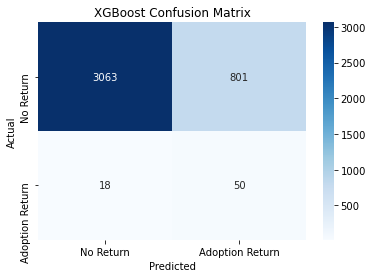

In [16]:
plot_confusion_matrix(y_test, xgboost_pred, "XGBoost")

Now, I want to examine the feature importance of my final model. XGBoost models have an attribute called gain score that I can use to infer feature importance. Gain score measure the relative increase in accuracy for including a feature on a branch.

In [13]:
# getting the "gain" score and sorting by gain score
gain_scores = fit_model.get_booster().get_score(importance_type='gain')
sorted_gain_scores = sorted(gain_scores.items(), key=lambda x: x[1])

In [14]:
top_10_gain_scores = (sorted_gain_scores[:-11:-1])

In [15]:
features, gain_score = zip(*top_10_gain_scores)
x_axis = np.arange(len(features))

In [16]:
clean_feature_names = ['Spay/Neuter', 'Intake Loc: Sonoma County', 'Intake Loc: Windsor',
                       'Intake Loc:Santa Rosa', 'Intake Cond: Healthy', 'Type: Dog',
                       'Intake Loc: Out of County', 'Intake Loc: Rohnert Park', 'Intake Cond: Manageable',
                       'Size: Med'
                      ]

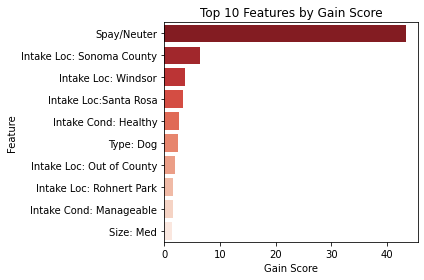

In [17]:
sns.barplot(gain_score, x_axis, palette='Reds_r', label=features, orient='h')
plt.title("Top 10 Features by Gain Score")
plt.xlabel("Gain Score")
plt.ylabel("Feature")
plt.yticks(x_axis, labels=clean_feature_names)
plt.tight_layout()
plt.savefig('images/feature_importance.png', format='png');

### 5. Tableau Prep
I want to be able to use longitude and latitude (for outcome location) as well as see the probabilities of an animal being an adoption return.

In [33]:
# prep data for classification
columns_to_keep = ["type", "size", "age", "gender", "has_name", "spay_neuter", "intake_condition", "pit_bull", "intake_location", "adopt_return"]
tableau_df = animal_df[columns_to_keep].copy()

# dropping 31 rows where size is null (0.1% of my data)
print(tableau_df[tableau_df["size"].isnull()].shape)
tableau_df = tableau_df[tableau_df["size"].notna()]

(31, 10)


In [34]:
xgboost = xgb.XGBClassifier(
                           n_estimators=20,
                           max_depth=47,
                           objective='binary:logistic',
                           learning_rate=0.225,
                           subsample=0.9,
                           scale_pos_weight=2.5,
                           reg_alpha=5,
                           reg_lambda=6.5
                           )

X = tableau_df.drop(columns=["adopt_return"])
X = pd.get_dummies(X)
y = tableau_df["adopt_return"]
fit_model = xgboost.fit(X, y)
tableau_df["adopt_return_predict_proba"] = fit_model.predict_proba(X)[:,1]

In [35]:
tableau_df.head()

,type,size,age,gender,has_name,spay_neuter,intake_condition,pit_bull,intake_location,adopt_return,adopt_return_predict_proba
0,DOG,MED,5.0,Male,1,0,UNKNOWN,0,SANTA ROSA,0,0.006924
1,DOG,MED,NaN,Female,0,0,HEALTHY,1,SONOMA COUNTY,0,0.006924
2,DOG,MED,NaN,Female,1,0,HEALTHY,0,SONOMA COUNTY,0,0.006924
3,DOG,SMALL,6.0,Male,1,1,UNKNOWN,0,SANTA ROSA,0,0.043706
4,DOG,LARGE,10.0,Female,1,1,HEALTHY,0,SANTA ROSA,0,0.052804


In [36]:
animal_df["latitude"] = animal_df.loc[animal_df["location"].notnull(),"location"].apply(lambda x: x.get('latitude'))
animal_df["longitude"] = animal_df.loc[animal_df["location"].notnull(),"location"].apply(lambda x: x.get('longitude'))
lat_long_df = animal_df.loc[:,["latitude", "longitude"]]
tableau_df = pd.merge(tableau_df, lat_long_df, left_index=True, right_on=lat_long_df.index, how='inner')
tableau_df.head()

,key_0,type,size,age,gender,has_name,spay_neuter,intake_condition,pit_bull,intake_location,adopt_return,adopt_return_predict_proba,latitude,longitude
0,0,DOG,MED,5.0,Male,1,0,UNKNOWN,0,SANTA ROSA,0,0.006924,38.486997,-122.749134
1,1,DOG,MED,NaN,Female,0,0,HEALTHY,1,SONOMA COUNTY,0,0.006924,NaN,NaN
2,2,DOG,MED,NaN,Female,1,0,HEALTHY,0,SONOMA COUNTY,0,0.006924,38.458384,-122.675588
3,3,DOG,SMALL,6.0,Male,1,1,UNKNOWN,0,SANTA ROSA,0,0.043706,38.424655,-121.438065
4,4,DOG,LARGE,10.0,Female,1,1,HEALTHY,0,SANTA ROSA,0,0.052804,38.458384,-122.675588


In [38]:
tableau_df.to_csv('data/tableau_df.csv')